### EXAMPLE 1: Deterministic Kuramoto-Sivashinsky 
In this example we show how one can approximate $e^{(\Delta t L/2 - 1)}/L$, using complex contour integration, where L is a operator arising from a spatial discretisation. 

Also contained in this example, is a explicit use of updating the class timestep values.

In [11]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)

 The dictionary is specified in models/ETD_KT_CM_JAX_Vectorised.py, and loaded in as follows:

In [12]:
signal_params = ConfigDict(KDV_params_2)
signal_params = ConfigDict(KS_params)
print(signal_params)

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.25
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 600
nx: 256
tmax: 150.0
xmax: 100.53096491487338
xmin: 0.0



Now we specify the model refered to as a signal model, by instantiating the class, and then specify the initial condition. 

In [13]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
signal_model.params.dt = signal_model.params.dt*0.1
signal_model.params.nt = signal_model.params.nt*10
signal_model.update_params(signal_model.params)# it is neccessary to update the derived parameters in the model, such as time dependent parameters
print(signal_params)

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.025
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 6000
nx: 256
tmax: 150.0
xmax: 100.53096491487338
xmin: 0.0



To run the model outputting all timesteps we run the signal model, with nmax timesteps.

In [14]:
key = jax.random.PRNGKey(0)
final, all = signal_model.run(initial_signal, signal_model.params.nt, None, key)
print(signal_model.params)


Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.025
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 6000
nx: 256
tmax: 150.0
xmax: 100.53096491487338
xmin: 0.0



Here we note that we have L diagonal, such that contour integration can be done on the points. 

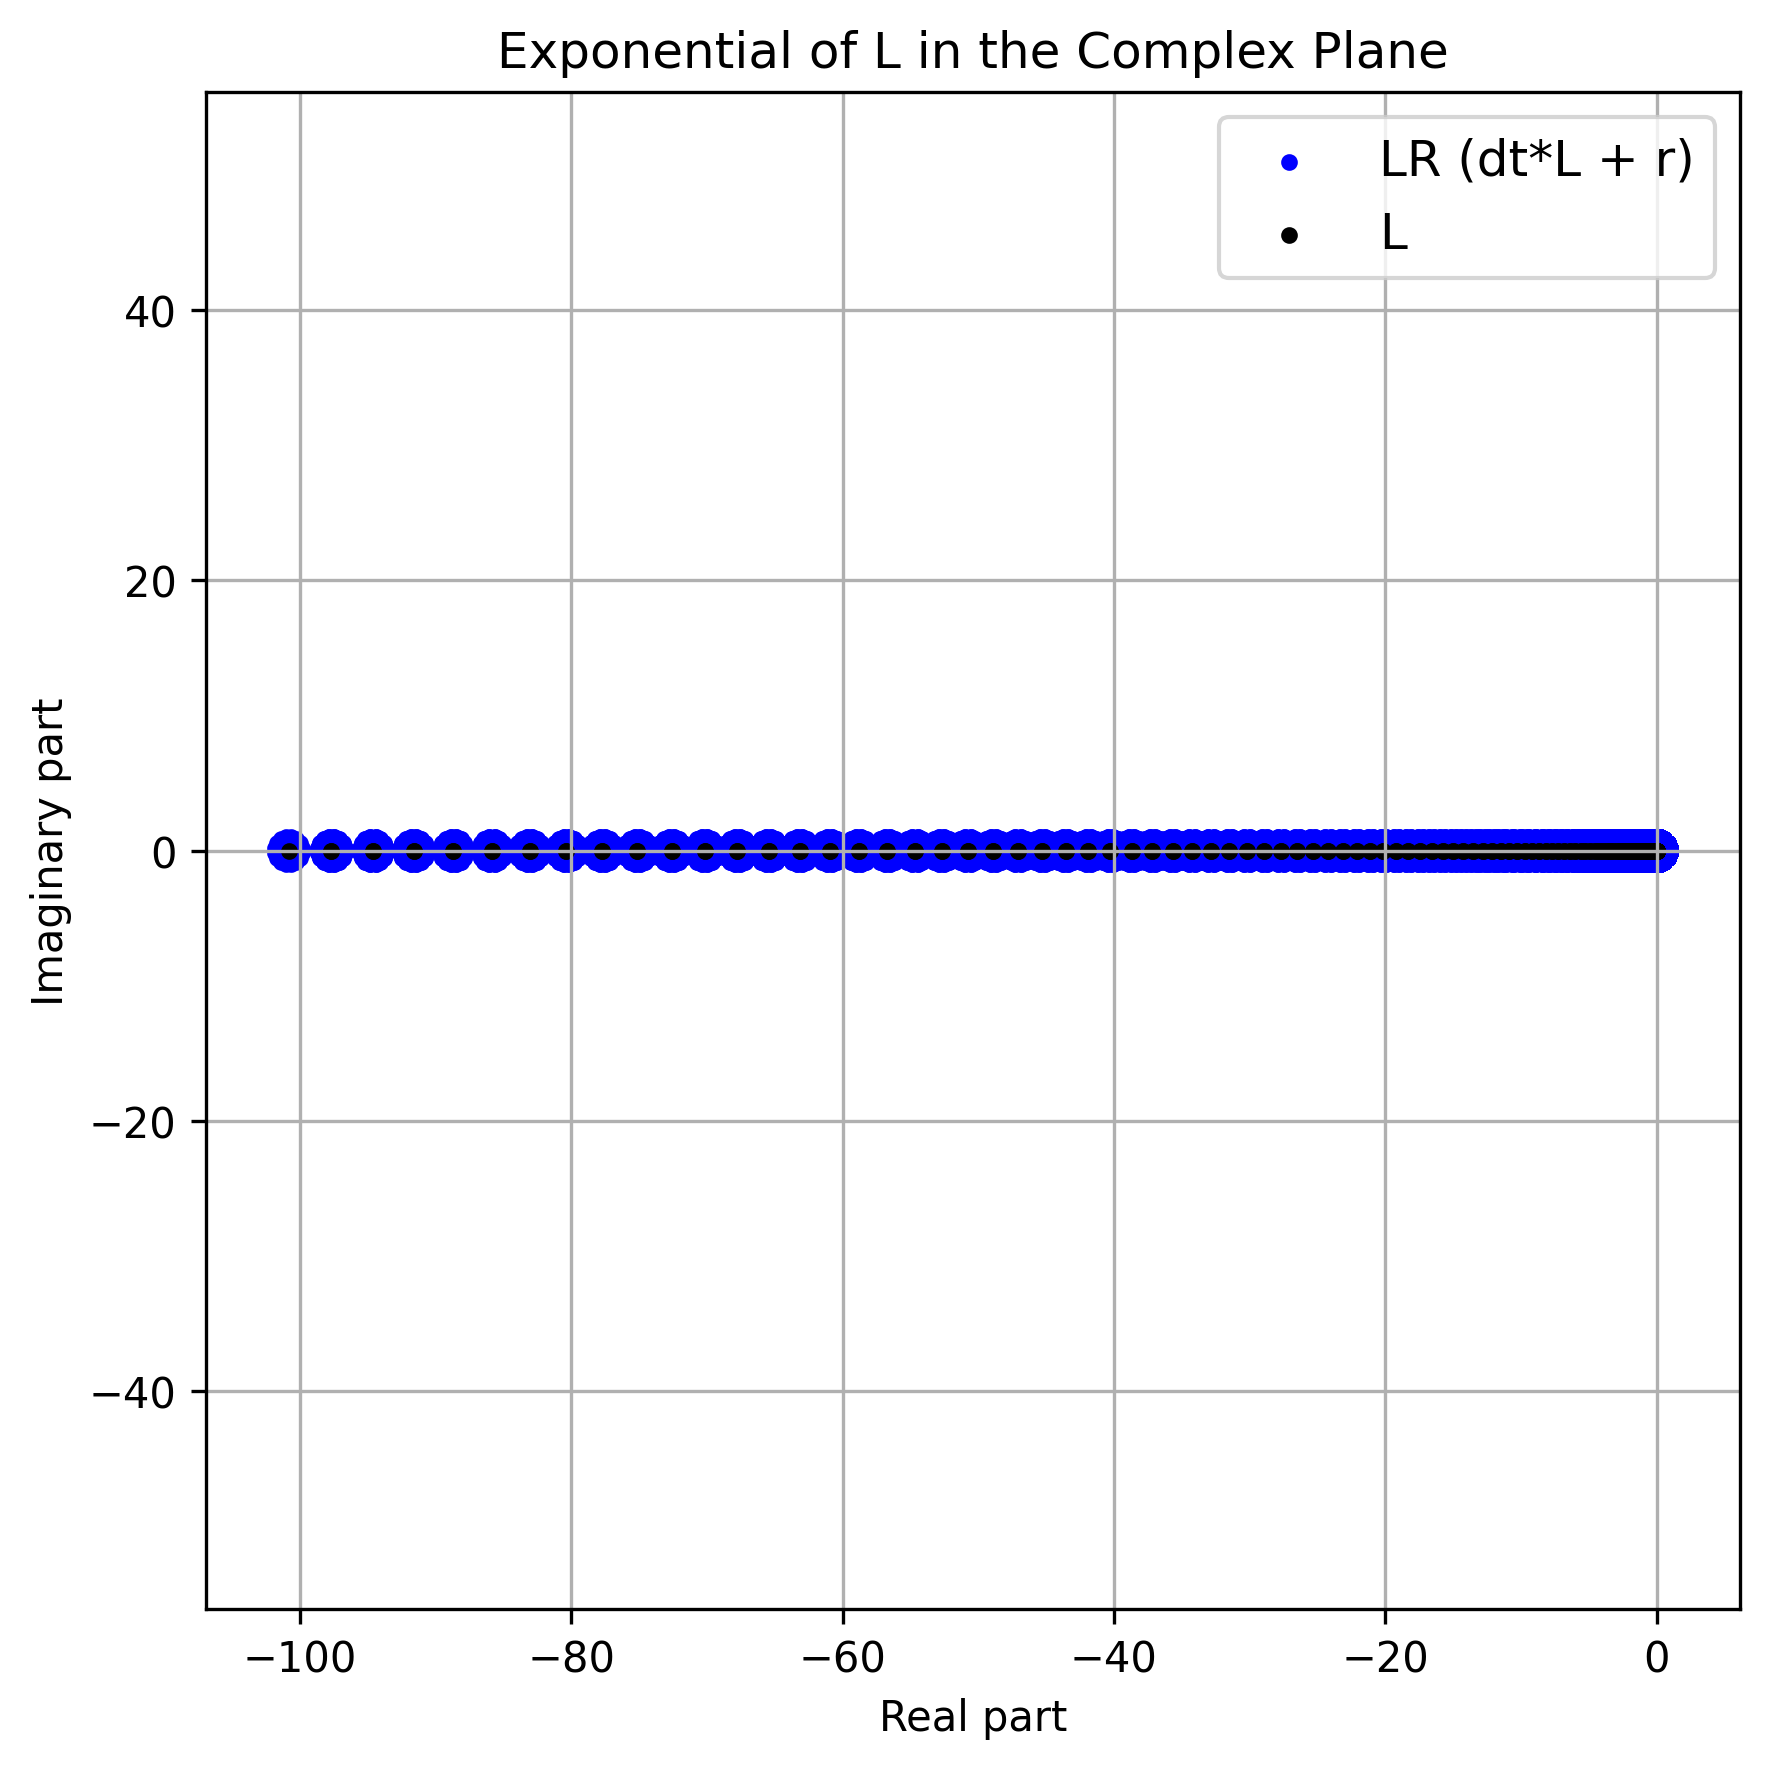

In [15]:
dt = signal_model.params.dt
A1 = signal_model.A1
A2 = signal_model.A2
L = signal_model.L
g = signal_model.g
k = signal_model.k
L = L

R  =  1
M  =  16
r  =  R * jnp.exp(2j * jnp.pi * (jnp.arange(1, M + 1) - 0.5) / M) # 1/M,...2M-1/M,
LR =  dt * L[:, None] + r[None, :] #
Q  =  dt * jnp.mean( (jnp.exp(LR / 2) - 1) / LR, axis=-1)
# per point in the operator L, we center a unit circle of radius R, and then compute the integral over the circle using the trapezium rule.


plt.figure(figsize=(6, 6),dpi=300)
#plt.plot(ans_0.real, ans_0.imag, 'r--', label='exp(dt L/2 - 1)/L at zero') 
plt.scatter(LR.real.flatten(), LR.imag.flatten(), label='LR (dt*L + r)', marker='.',c='b')
plt.scatter((L*dt).real, (L*dt).imag, label='L', marker='.',c='k')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Exponential of L in the Complex Plane')
plt.grid(True)
plt.axis('equal')
plt.legend(fontsize=12, loc='best', frameon=True)
plt.tight_layout()
plt.show()


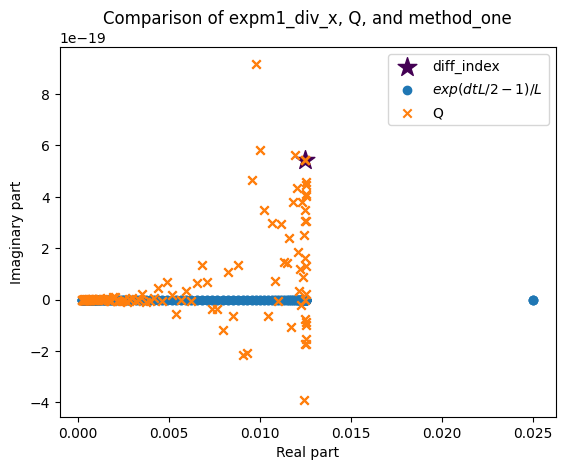

Index of largest difference: 0
ans[0] = (0.025+0j), ans_0[0] = (inf+nanj)
ans2 (Q) = (0.0125+5.421010862427522e-19j)
0j
L2 norm of the difference between Q and ans: 0.02165063509461097
L2 norm of the difference between Q and ans (excluding diff_idx): 0.01767766952966369


In [16]:
def method_one(dt,L):
    # Compute exp(dt*L/2) - 1 stably
    ans_0 = jnp.exp(dt*L/2 - 1)/L

    return ans_0
# Compute (exp(dt*L/2) - 1) / L stably
#jnp.expm1(L/2*dt) / (L * dt) = (dt L/2 + dt^2 L^2/8 + dt^3 L^3/48 + ... -1)/ (L * dt) = 
def expm1_div_x(dt,L):
    # Use jnp.where to avoid division by zero
    return dt * jnp.where(jnp.abs(L/2*dt) > 1e-15, jnp.expm1(L/2*dt) / (L * dt), 1.0)

def taylor_exp(dt, L):
    # Compute the Taylor series expansion of exp(dt*L/2) - 1
    ans = dt * L / 2 + (dt * L / 2)**2 / 2 + (dt * L / 2)**3 / 6 
    return (ans-1) / (L*dt)

def stable_exp_minus1_over_z(z, threshold=1e-3):
    """
    Compute e^{z - 1} / z in a numerically stable way for small z
    """
    # Use a Taylor series for small z
    def taylor_approx(z):
        # up to z^4 is usually enough
        return (1/z + 1 + z/2 + z**2/6 + z**3/24) * jnp.exp(-1)

    # Use original expression otherwise
    def normal_expr(z):
        return jnp.exp(z - 1) / z

    return jnp.where(jnp.abs(z) < threshold, taylor_approx(z), normal_expr(z))

ans = expm1_div_x( dt , L)
ans_0 = method_one(dt, L)# unsuitable due to zero division.
ans2 = Q
ans3 = taylor_exp(dt, L)
diff_idx = jnp.argmax(jnp.abs(ans - ans2))
plt.scatter(ans2[diff_idx].real, ans2[diff_idx].imag, label='diff_index',c=k[diff_idx], marker='*', s=200)
#plt.scatter(ans_0.real, ans_0.imag, label='exp(dt L/2 - 1)/L at zero no handling', marker='x')
plt.scatter(ans.real, ans.imag, label=f'$exp(dt L/2 - 1)/L$',marker='o')
plt.scatter(ans2.real, ans2.imag, label='Q', marker='x')
#plt.scatter(ans3.real, ans3.imag, label='Taylor expansion', marker='s')

plt.legend()
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Comparison of expm1_div_x, Q, and method_one')
plt.show()

# ans2 is Q, which is computed using complex contour integration to approximate (exp(dt*L/2) - 1)/L stably for all L.
# This avoids the division by zero and numerical instability present in ans_0 (method_one).

diff_idx = jnp.argmax(jnp.abs(ans - ans2))
print("Index of largest difference:", diff_idx)
print("ans[{}] = {}, ans_0[{}] = {}".format(diff_idx, ans[diff_idx], diff_idx, ans_0[diff_idx]))
print("ans2 (Q) =", ans2[diff_idx])
print(L[0])
# Compute the L2 norm of the difference between Q (ans2) and ans

l2_diff = jnp.linalg.norm(ans2 - ans)
print("L2 norm of the difference between Q and ans:", l2_diff)
# Compute the L2 norm of the difference between Q (ans2) and ans, excluding diff_idx
mask = jnp.arange(ans.size) != diff_idx
l2_diff_excl = jnp.linalg.norm(ans2[mask] - ans[mask])
print("L2 norm of the difference between Q and ans (excluding diff_idx):", l2_diff_excl)


This results in a (nt, E, nx) sized array, nt denotes the number of timesteps, E denotes the number of ensemble members, nx denotes the number of spatial points.

In [17]:
print(all.shape) # particles

(6000, 1, 256)


Here we insert the initial condition into the outputted solution. 

In [18]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
print(signal.shape)  # (nt+1, n_particles, n_states)

(1, 256)
(6000, 1, 256)
(6001, 1, 256)


We plot an interactive plot

In [19]:
def plot(time_index):
    plt.figure(figsize=(8, 4))
    plt.plot(signal_model.x, signal[time_index, 0, :], color='k', lw=2)
    plt.xlabel('Spatial coordinate $x$', fontsize=14)
    plt.ylabel('Signal $u(x)$', fontsize=14)
    plt.title(f'Kuramoto-Sivashinsky at $t={time_index * signal_model.params.dt:.2f}$', fontsize=16)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(signal_model.x[0], signal_model.x[-1])
    plt.tight_layout()
    plt.show()

interact(plot, time_index=(0, signal_model.params.nt))

interactive(children=(IntSlider(value=3000, description='time_index', max=6000), Output()), _dom_classes=('wid…

<function __main__.plot(time_index)>

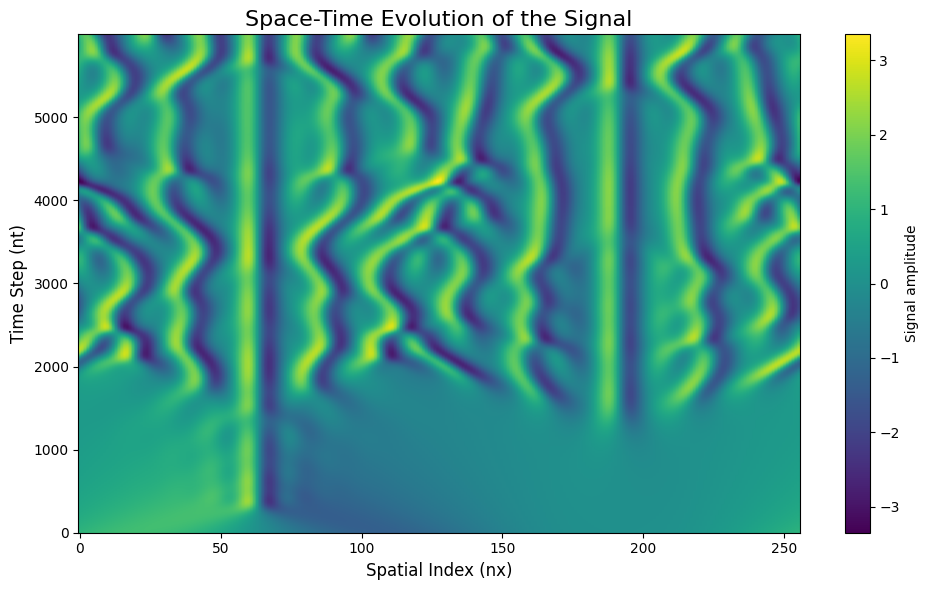

In [20]:
plt.figure(figsize=(10, 6))
plt.imshow(all[:, 0, :], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Signal amplitude')
plt.title('Space-Time Evolution of the Signal', fontsize=16)
plt.xlabel('Spatial Index (nx)', fontsize=12)
plt.ylabel('Time Step (nt)', fontsize=12)
plt.tight_layout()
plt.show()
